In [2]:
import pandas as pd
import scipy as sc
import glob
import os
import numpy as np
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline
%autosave 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Autosave disabled


In [2]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("talk")
    sns.set_style("whitegrid")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')

prepare_plot()

In [127]:
def read_energies(ff, system, state):

    file_mask = get_files(ff, system, state)
    print(file_mask)
    files = glob.glob(file_mask)
    files = [i for i in files if i[-2:] != "pl"]
    energies = []
    
    vdw, ele, bnd, ang, dih, v14, e14 = [], [], [], [], [], [], []
    
    for file in files:
        with open(file, "r") as f:
            for line in f.readlines()[10:]:
                words = line.rstrip().split()
                if words[0] == "L6":
                    vdw.append(float(words[3]))
                    ele.append(float(words[4]))
                elif words[0] == "L7":
                    bnd.append(float(words[2]))
                    ang.append(float(words[3]))
                    dih.append(float(words[4]))
                elif words[0] == "L8":
                    v14.append(float(words[1]))
                    e14.append(float(words[2]))
            
    print(len(bnd), len(ang), len(dih), len(v14), len(e14), len(vdw), len(ele))
    energies = {"Bond": bnd,
               "Angle": ang,
               "Dihedral": dih,
               "V14": v14,
               "E14": e14,
               "VDW": vdw,
               "Ele": ele,
               "Total": [sum(x) for x in zip(bnd, ang, dih, v14, e14, vdw, ele)]}
                    
    return pd.DataFrame(energies)

    
def get_files(ff, system, state):
    
    
    
    
    base = {"SMIRNOFF99Frosst": f"../smirnoff-host-guest-simulations/systems/",
              "BGBG-TIP3P": f"/home/dslochower/niel/projects/cds/wat6/bgbg-tip3p/"
    }
    
    systems = {"SMIRNOFF99Frosst": "smirnoff/",
              "BGBG-TIP3P": f""
    }
    
    states = {"SMIRNOFF99Frosst": {"attach": "a000",
                                  "release": "p045"},
            "BGBG-TIP3P": {"attach": "a00",
                           "release": "r00"}}
    
    mask = {"SMIRNOFF99Frosst": "prod*.mden",
              "BGBG-TIP3P": f"mden*"
    }
    
    if ff == "BGBG-TIP3P" and state == "release":
        system = f"{system[0]}-xxxx-s"
    
    return os.path.join(base[ff], system, systems[ff], states[ff][state], mask[ff])

In [128]:
smirnoff_initial = read_energies("SMIRNOFF99Frosst", "b-mch-p", "attach")
smirnoff_final = read_energies("SMIRNOFF99Frosst", "b-mch-p", "release")

../smirnoff-host-guest-simulations/systems/b-mch-p/smirnoff/a000/prod*.mden
1000000 1000000 1000000 1000000 1000000 1000000 1000000
../smirnoff-host-guest-simulations/systems/b-mch-p/smirnoff/p045/prod*.mden
1000000 1000000 1000000 1000000 1000000 1000000 1000000


In [129]:
gaff_initial = read_energies("BGBG-TIP3P", "b-mch-p", "attach")
gaff_final = read_energies("BGBG-TIP3P", "b-mch-p", "release")

/home/dslochower/niel/projects/cds/wat6/bgbg-tip3p/b-mch-p/a00/mden*
1000000 1000000 1000000 1000000 1000000 1000000 1000000
/home/dslochower/niel/projects/cds/wat6/bgbg-tip3p/b-xxxx-s/r00/mden*
1000000 1000000 1000000 1000000 1000000 1000000 1000000


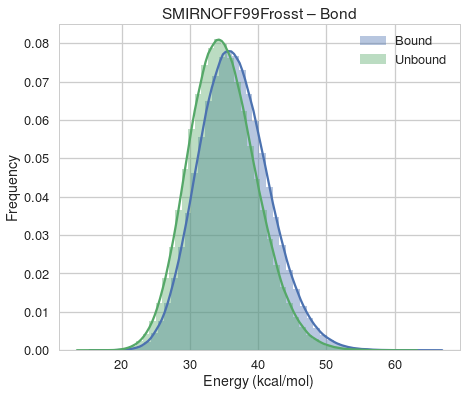

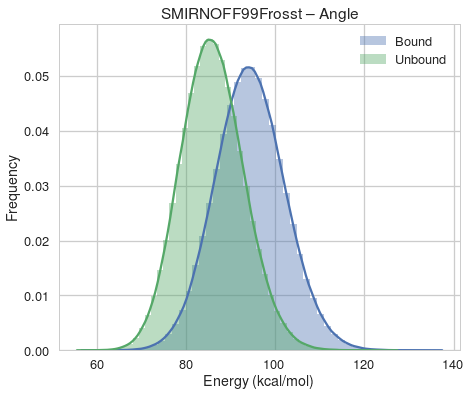

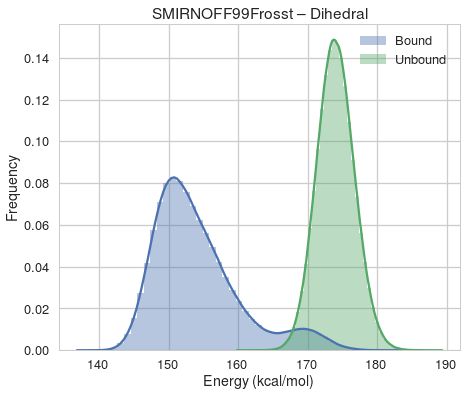

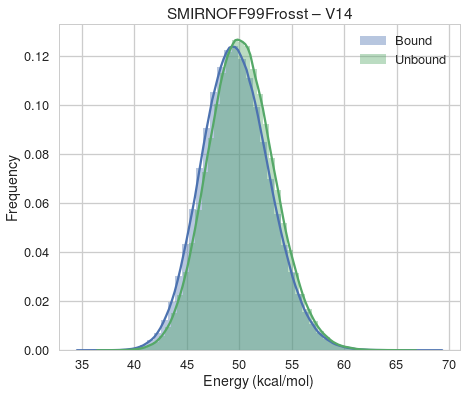

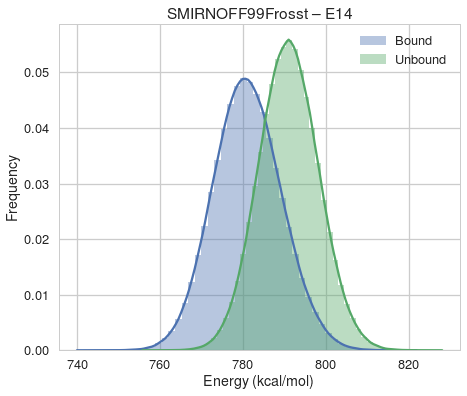

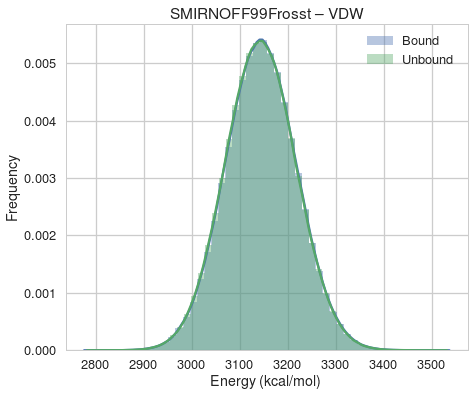

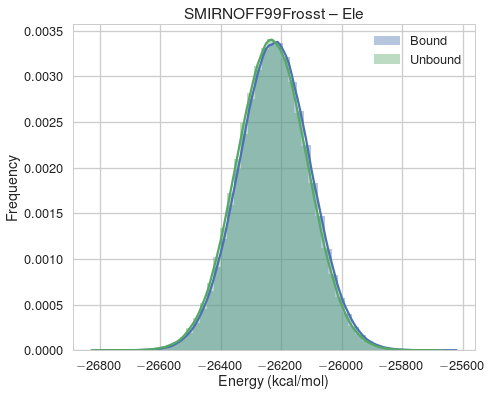

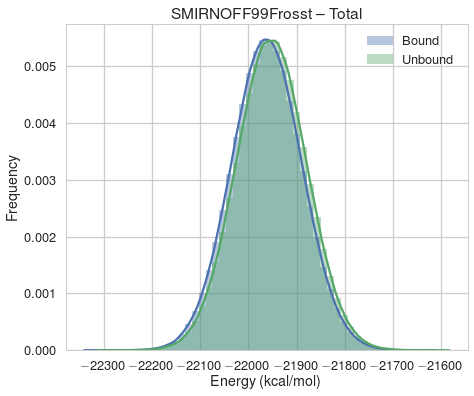

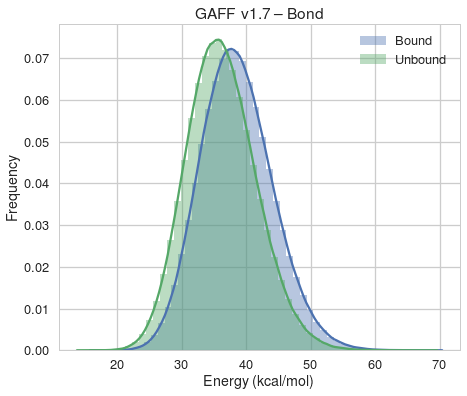

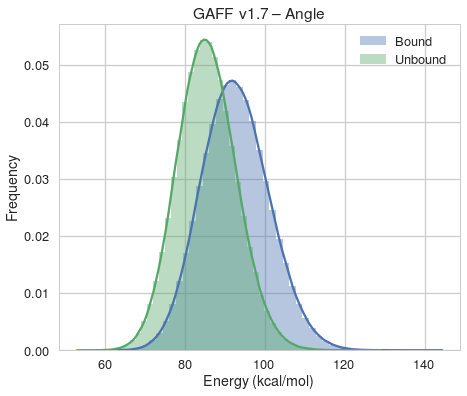

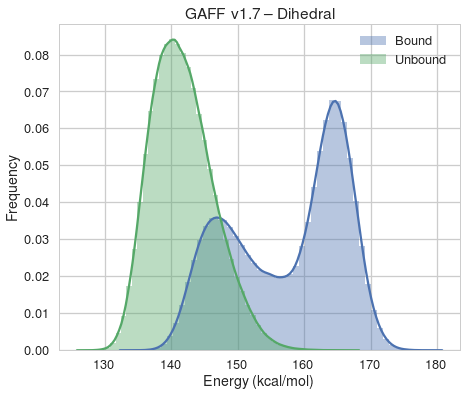

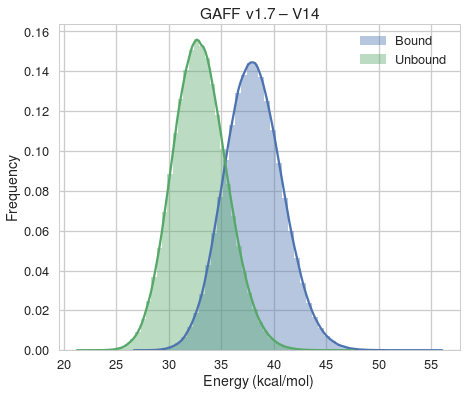

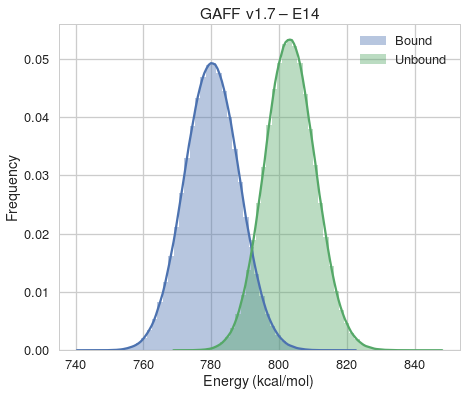

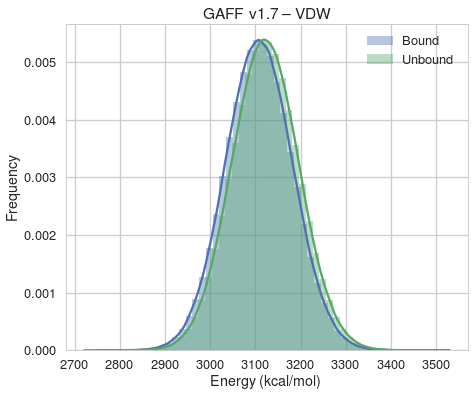

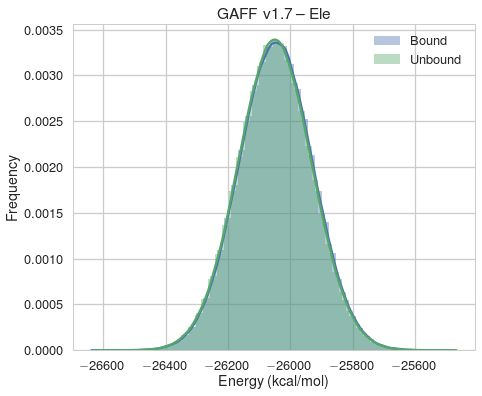

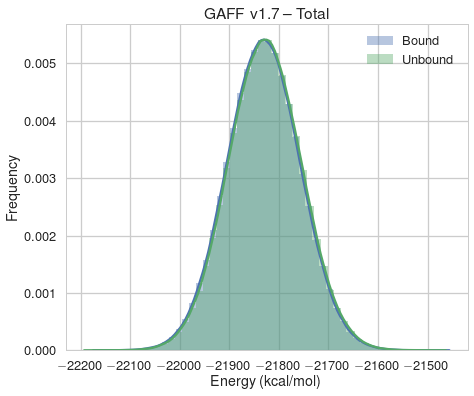

In [135]:
for component in ["Bond", "Angle", "Dihedral", "V14", "E14", "VDW", "Ele", "Total"]:
    fig = plt.figure(figsize=(6 * 1.2, 6))
    
    sns.distplot(smirnoff_initial[component], label="Bound")
    sns.distplot(smirnoff_final[component], label="Unbound")
    plt.title(f"SMIRNOFF99Frosst -- {component}")
    plt.xlabel("Energy (kcal/mol)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
for component in ["Bond", "Angle", "Dihedral", "V14", "E14", "VDW", "Ele", "Total"]:
    fig = plt.figure(figsize=(6 * 1.2, 6))
    
    sns.distplot(gaff_initial[component], label="Bound")
    sns.distplot(gaff_final[component], label="Unbound")
    plt.title(f"GAFF v1.7 -- {component}")
    plt.xlabel("Energy (kcal/mol)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

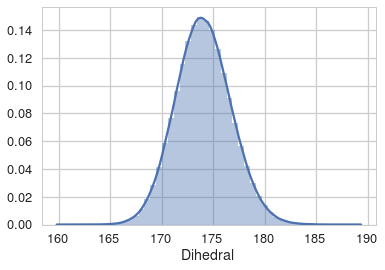

In [118]:
sns.distplot(smirnoff_final["Dihedral"])

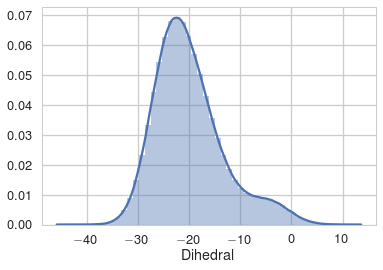

In [119]:
sns.distplot(smirnoff_initial["Dihedral"] - smirnoff_final["Dihedral"])

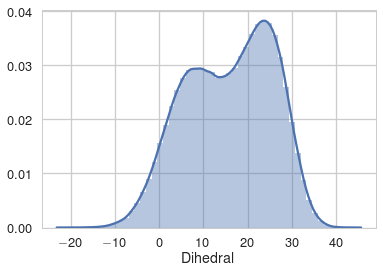

In [120]:
sns.distplot(gaff_initial["Dihedral"] - gaff_final["Dihedral"])

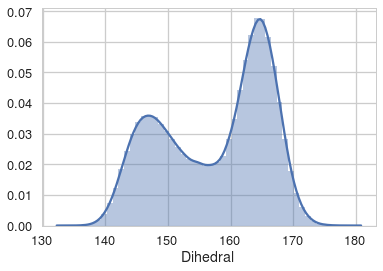

In [121]:
sns.distplot(gaff_initial["Dihedral"])

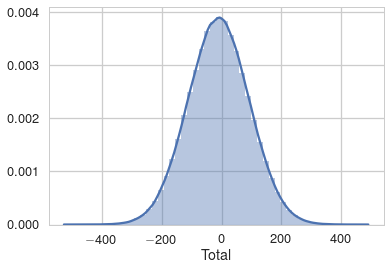

In [130]:
sns.distplot(smirnoff_initial["Total"] - smirnoff_final["Total"])

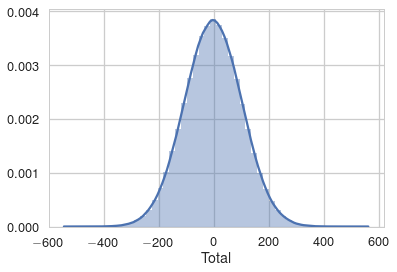

In [131]:
sns.distplot(gaff_initial["Total"] - gaff_final["Total"])